In [250]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
%matplotlib inline
import os
import yaml
from yaml import CLoader as Loader
from glob import glob
import regex as re

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    


In [251]:
def parse_tb_logs(nb_folds, logs_path, metrics_to_plot, threshold=0.75):
    values = defaultdict(list)

    for fold_nb in range(nb_folds):
        fold_string = f"fold_{fold_nb}"
        print(fold_string,  end = ' ')
        logs_fold_path = join(logs_path, "metrics_synth", fold_string)
        event_acc = EventAccumulator(logs_fold_path)
        event_acc.Reload()
        #print(event_acc.Tags())
        for tag in metrics_to_plot:
            try:
                _, step_nums, vals = zip(*event_acc.Scalars(tag))
                print(f'{tag} {len(vals)}, ',  end = '')
                if tag == 'val_acc':
                    print(f"Max_acc: {max(vals):.3}", end=" ")
                if len(vals) < 2 or ('acc' in tag and max(vals) < threshold):
                    print(f"{bcolors.FAIL}unsuccessful run{bcolors.ENDC}")
                    return defaultdict(list), dict()
                values[tag].append(list(np.around(vals, 4)))
                values[f'{tag}_step'].append(list(step_nums))
                values['fold_nb'].append(fold_nb)
            except:
                print(f"warning: {tag} not in logs", end=" ")
                #values[tag].append([])
                pass
        print()
        
    with open(join(logs_fold_path, 'hparams.yaml')) as file:
        hparams_list = yaml.load(file, Loader=Loader)
    
    fold_ckpts = [y for x in os.walk(logs_path) for y in glob(os.path.join(x[0], '*.ckpt'))]
    best_epochs = []
    patt_to_find = 'epoch='
    for fold_ckpt in fold_ckpts:
        idx_beg=fold_ckpt.rfind(patt_to_find)
        idx_end=fold_ckpt[idx_beg+1:].find('_')+idx_beg
        best_epochs.append(int(fold_ckpt[idx_beg+len(patt_to_find):idx_end+1]))
    #print("best ep", hparams_list)
    
    if len(best_epochs) > 0: hparams_list['best_epoch'] = int(np.mean(best_epochs))
    
    hparams_list.pop('args', None)
        
    return values, hparams_list

def interpolate_values(metrics_to_plot, values, tot_num_values=100, max_epochs=1000,
                      val_epochs_logged=False):
    interp_values = defaultdict(list)

    for metric_name in metrics_to_plot:
        val_cond = val_epochs_logged and 'val' in metric_name
        max_epochs_real = values['val_epoch'] if val_cond else values[f'{metric_name}_step']
        #print('max_epochs_real', max_epochs_real, val_epochs_logged)
        max_epochs_real = max(max(max_epochs_real)) 
        max_epochs = min(max_epochs, max_epochs_real)
        x = np.linspace(0, max_epochs, num=tot_num_values)
        temp_lists=[]
        if val_cond:
            metric_log_steps = values['val_epoch']
        else:
            metric_log_steps = values[f'{metric_name}_step']
            
        for steps, vals in zip(metric_log_steps, values[metric_name]):
            temp_lists.append(np.interp(x, steps, vals))
        interp_values[f'{metric_name}_interp_steps'] = list(x)
        interp_values[f'{metric_name}_interp_mean'] = np.mean(temp_lists, axis=0)
        interp_values[f'{metric_name}_interp_var'] = np.var(temp_lists, axis=0)
    
    return interp_values

def plot_metrics(metrics_to_plot, interp_values_df, ax, label, epochs_values=None, color=None):
    
    for i, metric_name in enumerate(metrics_to_plot):
        if epochs_values == None:
            epochs = interp_values_df[f'{metric_name}_interp_steps']
        else:
            epochs = np.linspace(0, max(max(epochs_values)), interp_values_df.shape[0])
            #print("max val ep: ", max(epochs)) 
        mean_val = interp_values_df[f'{metric_name}_interp_mean']
        var_val = interp_values_df[f'{metric_name}_interp_var']
        ax[i].plot(epochs, mean_val, label=label, color=color) #, yerr=var_val)
        ax[i].fill_between(epochs, mean_val-var_val, mean_val+var_val, alpha=0.2, facecolor='k')
        ax[i].set_title(metric_name)
        ax[i].set_xlabel("epoch")
        if 'acc' in metric_name:
            ax[i].plot(epochs, np.ones(interp_values_df.shape[0]), '--k', linewidth=1, alpha=0.1)
        
    return ax

def plot_agg_metrics(metrics_to_plot, logs_paths, checkpoints, nb_fold, 
                     name: str=None, tot_num_values=200, max_epochs=1000, 
                     plot_legend=0, val_epochs_logged=False, threshold=0.75):
        
    rejected_ckpts=[]
    highscore_table = []
    f,a = plt.subplots(len(metrics_to_plot),1)
    f.set_size_inches(10,14)
    f.tight_layout()
    plt.ylim(0,1.1)
    if not type(nb_fold)==list:
        nb_fold = [nb_fold]*len(checkpoints)
        
    for logs_path, ckpt_name, n_fold in zip(logs_paths, checkpoints, nb_fold):
        print(ckpt_name)
        match=re.search(re.compile("_d[0-9]"), ckpt_name)
        depth=int(match[0][-1]) 

        metric_values, hparams_list = parse_tb_logs(n_fold, logs_path, metrics_to_plot,
                                                    threshold=threshold)
        if len(list(metric_values)) == 0: 
            rejected_ckpts.append(ckpt_name)
            continue
            
        def create_run_dict(hparams_list, metric_values, ckpt_name):
            hparams_list['name'] = ckpt_name
            hparams_list['eval_steps'] = []
            hparams_list['best_score'] = max(max(metric_values['val_acc']))
            return hparams_list
        
        highscore_table.append(create_run_dict(hparams_list, metric_values, ckpt_name))   
        val_epochs_logged = 'val_epoch' in metric_values.keys()
        
        interp_values = interpolate_values(metrics_to_plot=['val_loss', 'val_acc'], 
                                           values=metric_values, 
                                           tot_num_values=tot_num_values, max_epochs=max_epochs, 
                                           val_epochs_logged=val_epochs_logged)
        interp_values_df = pd.DataFrame(interp_values)
        
        label_pos = [i for i in range(len(ckpt_name)) if ckpt_name.startswith('_', i)][4]
        #print(ckpt_name[label_pos+1:])
        epochs = metric_values['val_epoch'] if val_epochs_logged else None
        
        cmap = plt.get_cmap(cm_names[depth - min_d])
        lightness = (hparams_list['hidden_size'] * hparams_list['lr'] / max_h / max_lr) / 2 + 0.5
        color = cmap(lightness)
        label = None
        if plot_legend == 1:
            label = str(ckpt_name[label_pos+1:])
        if plot_legend == 2:
            label = str(f"depth={depth}") if lightness > 0.95 else None
        plot_metrics(metrics_to_plot=['val_loss', 'val_acc'], interp_values_df=interp_values_df, 
                     ax=a, label=label, epochs_values=epochs, color=color)
    if plot_legend > 0:
        for ax in a:
            ax.legend()        
        
    f.subplots_adjust(hspace=0.4)
    if name:
        f.savefig(f'../plots/{name}.jpg', dpi=300)
    
    return rejected_ckpts, highscore_table

In [252]:
#metrics_to_plot = ['val_loss', 'val_acc', 'val_ap', 'val_auroc', 
#                   'train_loss_epoch', 'train_acc', 'train_ap']

cm_names = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
metrics_to_plot = ['val_loss', 'val_acc', 'val_epoch']
nb_fold= 2
max_h = 1200
max_lr = 1.5
min_d = 5


In [51]:
checkpoints_d3 = []
checkpoints_d4 = []
checkpoints_d5 = ['ckpt_27098065_0704_2133_synth_rand_b0_d5']

checkpoints_d6 = ['ckpt_27098636_0804_1208_synth_rand_b0_d6']

checkpoints_rand = ['ckpt_27096585_0704_1437_synth_rand_b0_d3',
                    'ckpt_27096594_0704_1539_synth_rand_b0_d4',
                    'ckpt_27098065_0704_2133_synth_rand_b0_d5',
                   'ckpt_27098636_0804_1208_synth_rand_b0_d6']

checkpoints_b1 = ['ckpt_27096592_0704_1527_synth_um_b1_d3',
              'ckpt_27096593_0704_1538_synth_um_b1_d4']

checkpoints_b10 = ['ckpt_27097384_0704_1712_synth_um_b10_d3',
              'ckpt_27097385_0704_1740_synth_um_b10_d4']

checkpoints_b100 = ['ckpt_27096591_0704_1527_synth_um_b100_d3',
                  'ckpt_27098061_0704_2056_synth_um_b100_d4']

checkpoints_b1000 = ['ckpt_27104195_1104_1116_synth_um_b1000_d4',
                    'ckpt_27103506_1104_1044_synth_um_b1000_d3']

checkpoints_lr = ['ckpt_27104194_1104_1115_synth_um_b1000_d4',
                 'ckpt_27104195_1104_1116_synth_um_b1000_d4']


In [52]:
checkpoints_list = [checkpoints_d4, checkpoints_d5, checkpoints_d6,
                    checkpoints_rand, checkpoints_b1, checkpoints_b10,
                    checkpoints_b100, checkpoints_b1000, checkpoints_lr]

checkpoints_names = ['checkpoints_d4', 'checkpoints_d5', 'checkpoints_d6',
                    'checkpoints_rand', 'checkpoints_b1', 'checkpoints_b10',
                    'checkpoints_b100', 'checkpoints_b1000', 'checkpoints_lr']


In [138]:
for checkpoints, ckpt_name in zip(checkpoints_list, checkpoints_names):
    print(f'{bcolors.OKBLUE}{ckpt_name}{bcolors.ENDC}')
    metrics_paths = [f"../logs/{ckpt}/metrics_synth/" for ckpt in checkpoints]
    plot_agg_metrics(metrics_to_plot, 
                     metrics_paths, checkpoints, nb_fold, 
                     name=ckpt_name, tot_num_values=300, max_epochs=1200)
    plt.show()

NameError: name 'checkpoints_list' is not defined

#logged paths : 101 
27114502_1504_2052_synth_um_b1_d5
fold_0 val_loss 5, val_acc 5, Max_acc: 1.0 val_epoch 5, 
27122303_1904_1043_synth_um_b1_d7
fold_0 warning: val_loss not in logs warning: val_acc not in logs warning: val_epoch not in logs 
27122314_1904_1048_synth_um_b1_d9
fold_0 val_loss 10, val_acc 10, Max_acc: 0.653 val_epoch 10, 
27122293_1904_1027_synth_um_b1_d5
fold_0 val_loss 4, val_acc 4, Max_acc: 0.481 val_epoch 4, 
27114484_1504_2025_synth_um_b1_d9
fold_0 val_loss 7, val_acc 7, Max_acc: 0.068 val_epoch 7, 
27119235_1804_1236_synth_um_b1_d7
fold_0 warning: val_loss not in logs warning: val_acc not in logs warning: val_epoch not in logs 
27114496_1504_2036_synth_um_b1_d8
fold_0 val_loss 7, val_acc 7, Max_acc: 0.332 val_epoch 7, 
27114476_1504_2016_synth_um_b1_d6
fold_0 val_loss 8, val_acc 8, Max_acc: 0.959 val_epoch 8, 
27114449_1504_1925_synth_um_b1_d7
fold_0 warning: val_loss not in logs warning: val_acc not in logs warning: val_epoch not in logs 
27114500_1504_2043_synth

/Users/jeromjeromee/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jeromjeromee/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeromjeromee/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jeromjeromee/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/jeromjeromee/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


val_loss 12, val_acc 12, Max_acc: 0.918 val_epoch 12, 
27114466_1504_1951_synth_um_b1_d8
fold_0 val_loss 7, val_acc 7, Max_acc: 0.285 val_epoch 7, 
27114441_1504_1821_synth_um_b1_d5
fold_0 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 
27114455_1504_1927_synth_um_b1_d9
fold_0 val_loss 7, val_acc 7, Max_acc: 0.057 val_epoch 7, 
27122230_1904_1001_synth_um_b1_d7
fold_0 warning: val_loss not in logs warning: val_acc not in logs warning: val_epoch not in logs 
27114450_1504_1925_synth_um_b1_d8
fold_0 val_loss 7, val_acc 7, Max_acc: 0.13 val_epoch 7, 
27114474_1504_2007_synth_um_b1_d6
fold_0 val_loss 10, val_acc 10, Max_acc: 0.93 val_epoch 10, 
27114511_1504_2056_synth_um_b1_d8
fold_0 val_loss 7, val_acc 7, Max_acc: 0.383 val_epoch 7, 
27122332_1904_1055_synth_um_b1_d7
fold_0 warning: val_loss not in logs warning: val_acc not in logs warning: val_epoch not in logs 
27114495_1504_2037_synth_um_b1_d8
fold_0 val_loss 7, val_acc 7, Max_acc: 0.231 val_epoch 7, 
27114456_1504_1927_synth_um_b1_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


val_loss 7, val_acc 7, Max_acc: 0.277 val_epoch 7, 


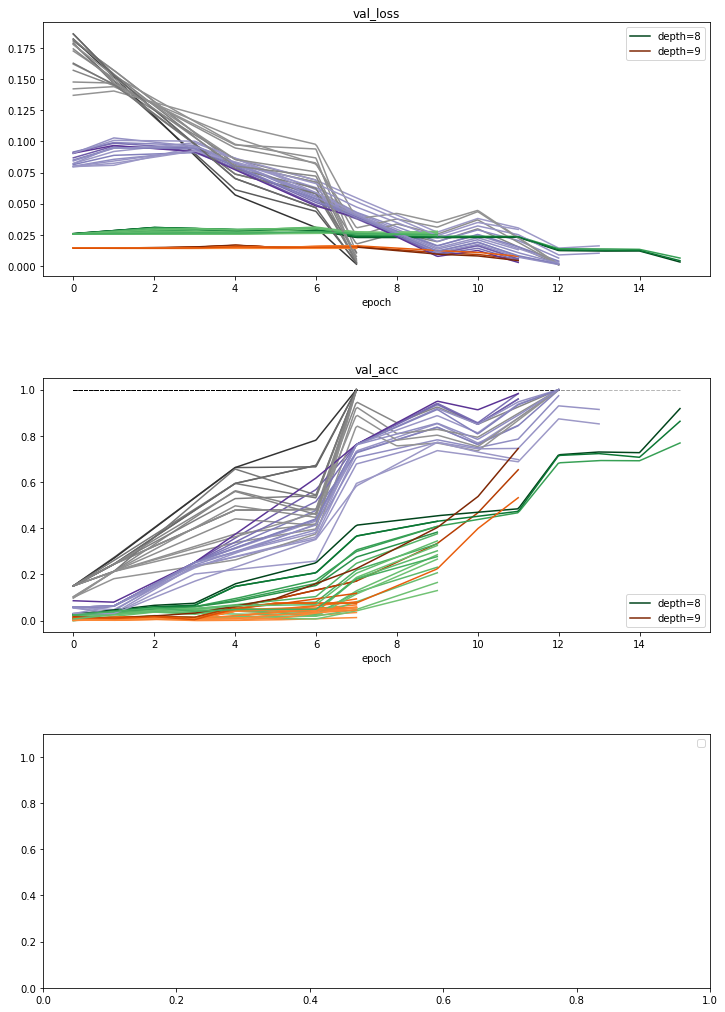

In [253]:
# loop over all files in directory

all_ckpt_dirs = os.listdir("../logs/")
all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
#all_ckpt_dirs = [el for el in all_ckpt_dirs if el not in rejected_ckpts]

logs_paths = [f"../logs/{ckpt}/" for ckpt in all_ckpt_dirs]
print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
rejected_ckpts, highscore_table = plot_agg_metrics(metrics_to_plot, logs_paths, 
                                                   all_ckpt_dirs, nb_fold=1, 
                                                   name="all_plots_>0.75", tot_num_values=300, 
                                                   max_epochs=7500, plot_legend=2,
                                                   threshold=0.01)
plt.show()

In [254]:
highscore_table = sorted(highscore_table, key=lambda d: d['best_score'], reverse=True) 
print(highscore_table[0])

print("{:<17} {:<4} {:<5} {:<3} {:<4} {:<4} {:<5}".format('name', 'lr', 'mode','h','clas', 'ep', 'best_score'))
for el in highscore_table:
    name=el['name']
    idx = [i for i in range(len(name)) if name.startswith('_', i)][3]
    name=name[idx+1:]
    print ("{:<17} {:<4} {:<5} {:<3} {:<4} {:<4} {:<5}".format(
                                    name, el['lr'], el['mode'], el['hidden_size'], 
                                    el['nb_classes'], el['best_epoch'], el['best_score']))


{'b_len': 1, 'eval_steps': [], 'hidden_size': 800, 'input_size': 200, 'lr': 1.0, 'lr_scheduler': None, 'max_batches_per_epoch': 1280, 'mode': 'um', 'nb_classes': 32, 'optimizer': 'sgd', 'best_epoch': 35, 'name': '27114502_1504_2052_synth_um_b1_d5', 'best_score': 1.0}
name              lr   mode  h   clas ep   best_score
um_b1_d5          1.0  um    800 32   35   1.0  
um_b1_d5          0.5  um    400 32   90   1.0  
um_b1_d5          1.5  um    100 32   35   1.0  
um_b1_d5          1.5  um    800 32   35   1.0  
um_b1_d5          1.0  um    400 32   35   1.0  
um_b1_d6          1.5  um    100 64   90   1.0  
um_b1_d5          1.5  um    50  32   35   1.0  
um_b1_d5          0.5  um    200 32   90   1.0  
um_b1_d5          0.5  um    50  32   90   1.0  
um_b1_d5          0.5  um    100 32   90   1.0  
um_b1_d5          1.5  um    200 32   35   1.0  
um_b1_d6          1.5  um    50  64   90   1.0  
um_b1_d5          1.0  um    100 32   35   1.0  
um_b1_d6          1.0  um    400 64   90 

In [249]:
a=[0, 2, 5, 9, 14, 20, 27, 35, 44, 54, 65, 77, 90] 
b=5
a.index(b)

2